<a href="https://colab.research.google.com/github/ArivCR7/Backpropagation-algorithms/blob/master/GDalgorithms_vectorized_binaryclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_circles

#Generate Data

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

In [33]:
data, label = make_circles(n_samples=1000, noise=0.2, random_state=0, factor=0.3)
print(data.shape, label.shape)

(1000, 2) (1000,)


In [222]:
X_train, X_test, Y_train, Y_test = train_test_split(data, label, stratify=label, random_state=0)
print(X_train.shape, Y_train.shape)

(750, 2) (750,)


In [0]:
Y_train_reshaped= Y_train.reshape(-1,1)
Y_test_reshaped = Y_test.reshape(-1,1)

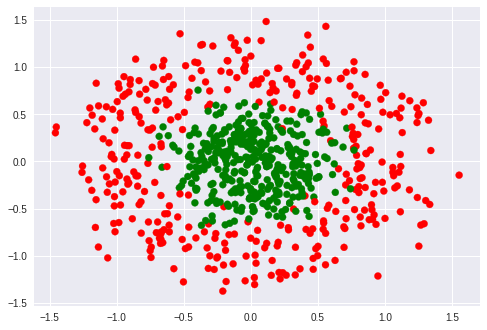

In [35]:
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train, cmap=my_cmap)
plt.show()

# FF Class

In [0]:
class FFNet:
  def __init__(self, W1, W2, W3):
    self.params = {}
    self.params['W1'] = W1.copy()
    self.params['B1'] = np.zeros((1,2))
    self.params['W2'] = W2.copy()
    self.params['B2'] = np.zeros((1,2))
    self.params['W3'] = W3.copy()
    self.params['B3'] = np.zeros((1,1))
    self.num_layers = 3
    self.update_params = {}
    self.gradients = {}
    self.prev_update_params = {}
    for i in range(1,self.num_layers+1):
      self.update_params['v_w'+str(i)] = 0
      self.update_params['v_b'+str(i)] = 0
      self.update_params['m_w'+str(i)] = 0
      self.update_params['m_b'+str(i)] = 0
      self.prev_update_params['v_w'+str(i)] = 0
      self.prev_update_params['v_b'+str(i)] = 0
    
  def activation(self, X):
    return(1.0/(1.0 + np.exp(-X)))
  
  def grad_activation(self, X):
    return(X*(1-X))
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    #print(Y_pred)
    #print(Y_pred.shape)
    return(np.array(Y_pred))
  
  def forward_pass(self, X, params=None):
    if(params is None):
      params = self.params
    self.A1 = np.matmul(X, params['W1']) + params['B1'] #(Nx2) x (2x2) -> (Nx2)
    self.H1 = self.activation(self.A1) #(Nx2)
    self.A2 = np.matmul(self.H1, params['W2']) + params['B2'] #(Nx2) x (2x2) -> (Nx2)
    self.H2 = self.activation(self.A2) #(Nx2)
    self.A3 = np.matmul(self.H2, params['W3']) + params['B3'] #(Nx2)x (2x1) -> (Nx1)
    self.H3 = self.activation(self.A3) #(Nx1)
    return(self.H3)
  
  def grad(self, X, Y, params=None):
    if(params is None):
      params = self.params
    self.forward_pass(X, params)
    self.gradients['dA3'] = self.H3 - Y #(Nx1)
    self.gradients['dW3'] = np.matmul(self.H2.T, self.gradients['dA3']) #(2xN) x (Nx1) -> (2x1)
    self.gradients['dB3'] = np.sum(self.gradients['dA3'], axis=0).reshape(1,-1) #(1x1)
    self.gradients['dH2'] = np.matmul(self.gradients['dA3'], params['W3'].T) #(Nx1) x (1x2) -> (Nx2)
    self.gradients['dA2'] = np.multiply(self.gradients['dH2'], self.grad_activation(self.A2)) #(Nx2)
    self.gradients['dW2'] = np.matmul(self.H1.T, self.gradients['dA2']) #(2xN) x (Nx2) -> (2x2)
    self.gradients['dB2'] = np.sum(self.gradients['dA2'], axis=0).reshape(1,-1) #(1x2)
    self.gradients['dH1'] = np.matmul(self.gradients['dA2'], params['W2'].T) #(Nx2) x (2x2) -> (Nx2)
    self.gradients['dA1'] = np.multiply(self.gradients['dH1'], self.grad_activation(self.A1)) #(Nx2)
    self.gradients['dW1'] = np.matmul(X.T, self.gradients['dA1']) #(2xN) x (Nx2) -> (2x2)
    self.gradients['dB1'] = np.sum(self.gradients['dA1'], axis=0).reshape(1,-1)

  def fit(self, X, Y, epochs=500, eta=0.1, mini_batch_size=100, algo='GD', gamma=0.8, epsilon=1e-8, beta=0.9, beta1=0.9, beta2=0.9, display_loss=True):
    
    if(display_loss):
      loss ={}
    
    m=X.shape[0]
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      
      if(algo=='GD'):
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.params['W'+str(i)] -= eta * (self.gradients['dW'+str(i)]/m)
          self.params['B'+str(i)] -= eta * (self.gradients['dB'+str(i)]/m)
      
      elif(algo=='Minibatchgd'):
        for k in range(0,m,mini_batch_size):
          self.grad(X[k:k+mini_batch_size], Y[k:k+mini_batch_size])
          for i in range(1, num_layers+1):
            self.params['W'+str(i)] -= eta * (self.gradients['dW'+str(i)]/mini_batch_size)
            self.params['B'+str(i)] -= eta * (self.gradients['dB'+str(i)]/mini_batch_size)
          
      elif(algo=='Momentum'):
        self.grad(X,Y)
        for i in range(1,self.num_layers+1):
          self.update_params['v_w'+str(i)] = gamma * self.update_params['v_w'+str(i)] + eta * self.gradients['dW'+str(i)]/m
          self.update_params['v_b'+str(i)] = gamma * self.update_params['v_b'+str(i)] + eta * self.gradients['dB'+str(i)]/m
          self.params['W'+str(i)] -= self.update_params['v_w'+str(i)]
          self.params['B'+str(i)] -= self.update_params['v_b'+str(i)]
      
      elif algo == "NAG":
        temp_params = {}
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)]=gamma*self.prev_update_params["v_w"+str(i)]
          self.update_params["v_b"+str(i)]=gamma*self.prev_update_params["v_b"+str(i)]
          temp_params["W"+str(i)]=self.params["W"+str(i)]-self.update_params["v_w"+str(i)]
          temp_params["B"+str(i)]=self.params["B"+str(i)]-self.update_params["v_b"+str(i)]
        self.grad(X,Y,temp_params)
        for i in range(1,self.num_layers+1):
          self.update_params["v_w"+str(i)] = gamma *self.update_params["v_w"+str(i)] + eta * (self.gradients["dW"+str(i)]/m)
          self.update_params["v_b"+str(i)] = gamma *self.update_params["v_b"+str(i)] + eta * (self.gradients["dB"+str(i)]/m)
          self.params["W"+str(i)] -= eta * (self.update_params["v_w"+str(i)])
          self.params["B"+str(i)] -= eta * (self.update_params["v_b"+str(i)]) 
        self.prev_update_params=self.update_params 
        
      elif(algo=='AdaGrad'):
        self.grad(X, Y)
        for i in range(1,self.num_layers+1):
          self.update_params['v_w'+str(i)] += self.gradients['dW'+str(i)]**2
          self.update_params['v_b'+str(i)] += self.gradients['dB'+str(i)]**2
          self.params['W'+str(i)] -= eta/(np.sqrt(self.update_params['v_w'+str(i)])+epsilon)*self.gradients['dW'+str(i)]
          self.params['B'+str(i)] -= eta/(np.sqrt(self.update_params['v_b'+str(i)])+epsilon)*self.gradients['dB'+str(i)]
        print(self.params['W1'])
        
      elif(algo=='RMSProp'):
        self.grad(X,Y)
        for i in range(1,self.num_layers+1):
          self.update_params['v_w'+str(i)] = beta*self.update_params['v_w'+str(i)] + (1-beta)*self.gradients['dW'+str(i)]**2
          self.update_params['v_b'+str(i)] = beta*self.update_params['v_b'+str(i)] + (1-beta)*self.gradients['dB'+str(i)]**2
          self.params['W'+str(i)] -= eta/(np.sqrt(self.update_params['v_w'+str(i)])+epsilon)*self.gradients['dW'+str(i)]
          self.params['B'+str(i)] -= eta/(np.sqrt(self.update_params['v_b'+str(i)])+epsilon)*self.gradients['dB'+str(i)]
      
      elif(algo=='Adam'):
        self.grad(X,Y)
        num_updates=0
        for i in range(1,self.num_layers+1):
          num_updates+=1
          self.update_params['m_w'+str(i)] = beta1*self.update_params['m_w'+str(i)] + (1-beta1)*self.gradients['dW'+str(i)]
          self.update_params['m_b'+str(i)] = beta1*self.update_params['m_b'+str(i)] + (1-beta1)*self.gradients['dB'+str(i)]
          self.update_params['v_w'+str(i)] = beta2*self.update_params['v_w'+str(i)] + (1-beta2)*self.gradients['dW'+str(i)]**2
          self.update_params['v_b'+str(i)] = beta2*self.update_params['v_b'+str(i)] + (1-beta2)*self.gradients['dB'+str(i)]**2
          m_w_c = self.update_params['m_w'+str(i)] / (1 - np.power(beta1, num_updates))
          m_b_c = self.update_params['m_b'+str(i)] / (1 - np.power(beta1, num_updates))
          v_w_c = self.update_params['v_w'+str(i)] / (1 - np.power(beta1, num_updates))
          v_b_c = self.update_params['v_b'+str(i)] / (1 - np.power(beta1, num_updates))
          self.params['W'+str(i)] -= eta/(np.sqrt(v_w_c)+epsilon)*m_w_c
          self.params['B'+str(i)] -= eta/(np.sqrt(v_b_c)+epsilon)*m_b_c
        
      if(display_loss):
        Y_pred = self.predict(X)
        loss[epoch] = log_loss(Y, Y_pred)
      
    

In [0]:
W1 = np.random.randn(2,2) 
W2 = np.random.randn(2,2)
W3 = np.random.randn(2,1)
ffn = FFNet(W1, W2, W3)

In [0]:
ffn.fit(X_train, Y_train_reshaped, epochs=2000, eta=5e-1, algo='RMSProp', mini_batch_size=200)

In [0]:
def print_accuracy():
  Y_train_pred = ffn.predict(X_train)
  Y_train_pred = np.array(Y_train_pred > 0.5).astype('int').ravel()
  train_acc = accuracy_score(Y_train_pred, Y_train)
  Y_test_pred = ffn.predict(X_test)
  Y_test_pred = np.array(Y_test_pred > 0.5).astype('int').ravel()
  test_acc  = accuracy_score(Y_test_pred, Y_test)
  print(Y_test_pred)
  print('Train acc: {}, Test acc: {}'.format(train_acc,test_acc))
  plt.scatter(X_train[:,0], X_train[:,1], c=Y_train_pred, cmap=my_cmap, s = 10*(np.abs(Y_train_pred - Y_train)+0.2))
  plt.show()
 

[0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1
 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1]
Train acc: 0.6146666666666667, Test acc: 0.616


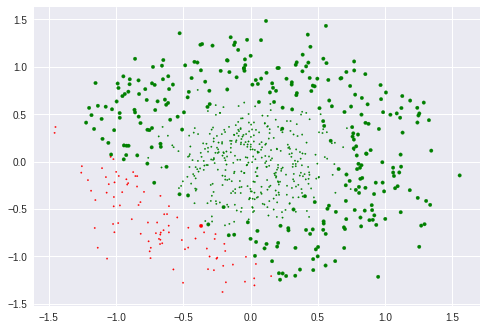

In [278]:
print_accuracy()

In [160]:
print(Y_test_pred)

NameError: ignored